In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import cv2
from cv2 import imread
import pandas as pd
import seaborn as sns

from numpy.linalg import norm

# 0. Итоговый функционал (для проверки задания)

Для проверки необходимо выполнить три последующие ячейки, после этого передать в функцию detect_fingers изображение в формате OpenCV2-Image. Если принятое функцией решение вызывает вопросы -- можно передать флаг visualize=True, тогда функция дополнительно отобразит два изображения: черно-белую маску, оставшуюся после дилатации, и области нарушения выпоклой оболочки ладони. 

In [3]:
def classify(feature):
    if feature > 4.5 or feature < 0.3:
        return 0
    elif feature > 1.8:
        return 4
    elif feature > 1.05:
        return 3
    elif feature > 0.66:
        return 2
    else:
        return 1
    
def to_answer(triangles):
    if len(triangles) == 4:
        return "1-1-1-1-1"
    elif set(triangles) == set([1,2,3]):
        return "1-1-1-2"
    elif set(triangles) == set([1,2,4]):
        return "1-1-2-1"
    elif set(triangles) == set([1,3,4]):
        return "1-2-1-1"
    elif set(triangles) == set([2,3,4]):
        return "2-1-1-1"
    elif set(triangles) == set([1,2]):
        return "1-1-3"
    elif set(triangles) == set([1,3]):
        return "1-2-2"
    elif set(triangles) == set([1,4]):
        return "1-3-1"
    elif set(triangles) == set([2,3]):
        return "2-1-2"
    elif set(triangles) == set([2,4]):
        return "2-2-1"
    elif set(triangles) == set([3,4]):
        return "3-1-1"
    elif set(triangles) == set([1]):
        return "1-4"
    elif set(triangles) == set([2]):
        return "2-3"
    elif set(triangles) == set([3]):
        return "3-2"
    elif set(triangles) == set([4]):
        return "4-1"
    elif set(triangles) == set([]):
        return "5"
    
def angle(A, B, C):
    BA = np.array(A)-np.array(B)
    BC = np.array(C)-np.array(B)
    return np.degrees(np.arccos(BA.dot(BC)/(np.linalg.norm(BA)*np.linalg.norm(BC))))

In [12]:
def detect_fingers(img, visualize=False):
    ret, thresh = cv2.threshold(img,80,255,cv2.THRESH_BINARY)
    median = cv2.medianBlur(thresh, 11)
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(median,kernel,iterations = 2)
    _, contours, hierarchy = cv2.findContours(dilation,2,1)
    cnt_idx = np.argmax([cv2.contourArea(cnt) for cnt in contours])
    cnt = contours[cnt_idx]
    hull = cv2.convexHull(cnt,returnPoints = False)
    defects = cv2.convexityDefects(cnt,hull)
    img2 = img.copy()
    angles = []
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    centroid = tuple([cx, cy])
    ok_defects = sorted(filter(lambda x: x[0][3] > 20000, defects), 
                        key=lambda x: np.linalg.norm(cnt[x[0][2]][0] - centroid), reverse=True)
    triangles = []
    for defect in ok_defects:
        s,e,f,d = defect[0]
        start = tuple(cnt[s][0])
        end = tuple(cnt[e][0])
        far = tuple(cnt[f][0])
        if angle(start, far, end) < 100 and angle(start, far, end) > 10:
            feature = np.round(angle(far, start, end)/angle(far, end, start), 2)
            k = classify(feature)
            if k in triangles:
                if k == 2:
                    k = 1
                elif k == 1:
                    k = 2
                elif k == 4:
                    k = 3
                elif k == 3:
                    k = 4
            if k != 0:
                triangles.append(k)
        if visualize:
            cv2.line(img2,start,end,[255,0,0],2)
            cv2.circle(img2,far,5,[255,0,0],-1)
            cv2.circle(img2,centroid, 5,[255,0,0],-1)
        if len(triangles) == 4:
            break
    if visualize:
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        ax1.imshow(dilation)
        ax1.set_title("Dilatated mask")
        ax2.imshow(img2)
        ax2.set_title("Convexity deffects map")
    return to_answer(triangles)

## 1. Считаем набор данных

In [9]:
train_dir = "train"

In [10]:
orig_dir = os.getcwd()
os.chdir(orig_dir)
data = [imread(os.path.join(train_dir, file_name), cv2.IMREAD_GRAYSCALE)[:,:-15] for file_name in os.listdir(train_dir)]

'2-3'

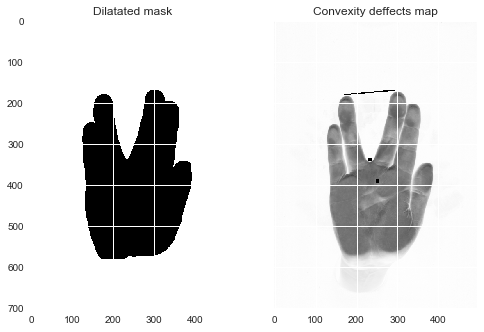

In [13]:
detect_fingers(data[288], visualize=True)

## Подбор порогов для классификации

В качестве признакового описания фрагментов "между пальцев" используется всего один признак: отношение углов у точки начала и точки конца. В силу нежелания подбирать среднее соотношение длин человеческих пальцев была размечена небольшая часть выборки из 10 картинок. Разметка лежит в файле "fingers2.csv".

Классам были даны следующие метки: <br>

1) Между мизинцем и безымяным <br> 
2) Между безымяным и средним <br>
3) Между средним и указательным <br>
4) Между указательным и большим <br>

In [15]:
X = pd.read_csv("fingers2.csv", sep=",")

In [17]:
X[:10]

,Unnamed: 0,id,feature,answer
0,0,95,2.45,4
1,1,95,0.59,1
2,2,95,0.65,2
3,3,9,2.15,4
4,4,9,1.52,3
5,5,9,0.54,1
6,6,9,0.72,2
7,7,295,3.51,4
8,8,295,1.32,3
9,9,295,0.84,2


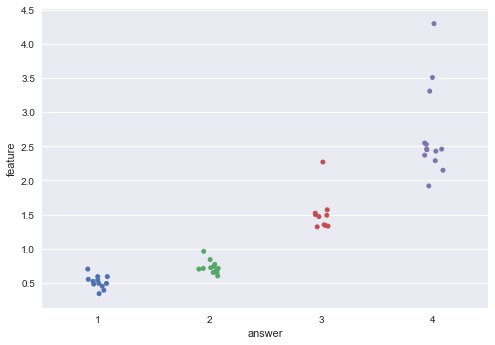

In [131]:
sns.stripplot(x="answer", y="feature", data=X, jitter=True)

По графику были подобраны следующие пороги:

In [19]:
def classify(feature):
    if feature > 4.5 or feature < 0.3:
        return 0
    elif feature > 1.8:
        return 4
    elif feature > 1.05:
        return 3
    elif feature > 0.66:
        return 2
    else:
        return 1

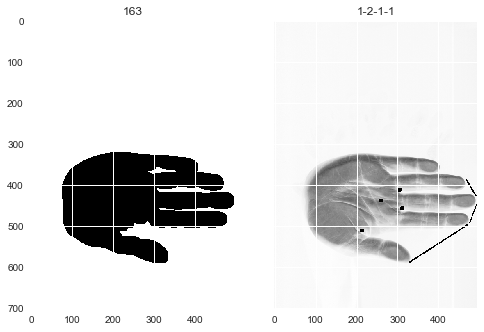

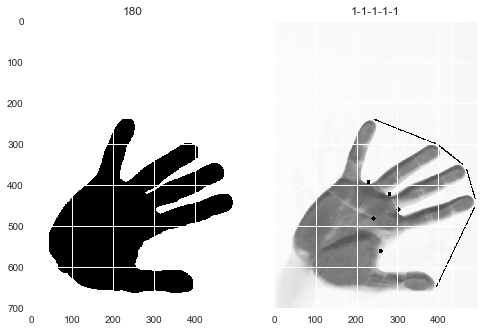

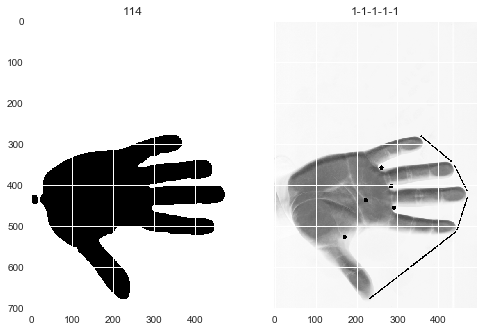

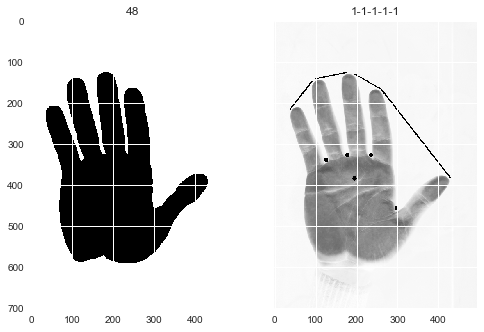

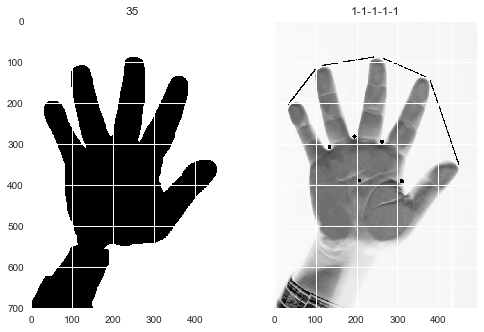

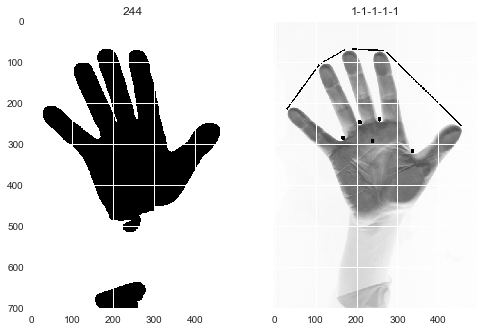

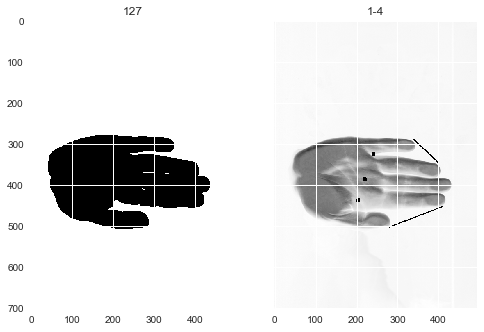

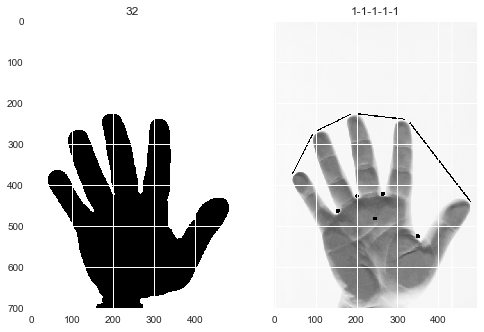

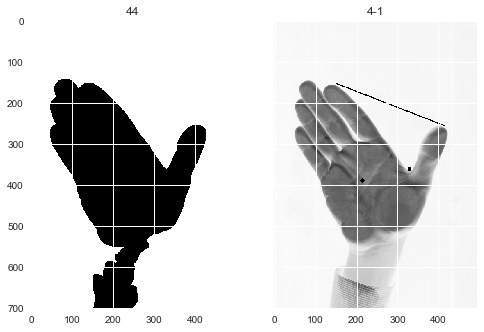

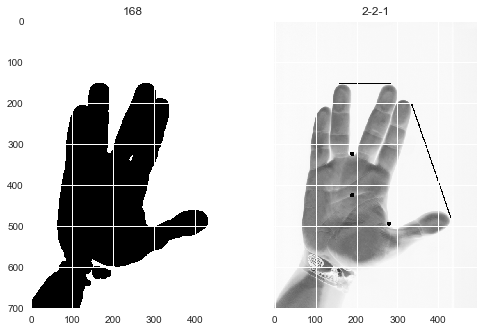

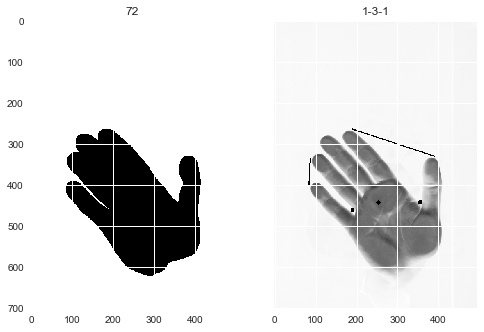

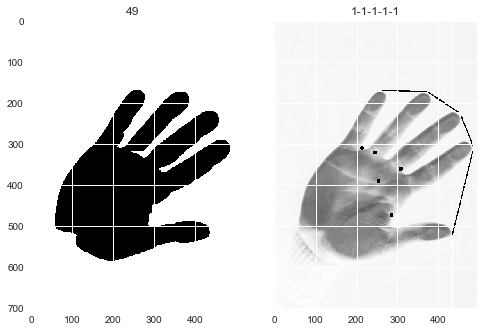

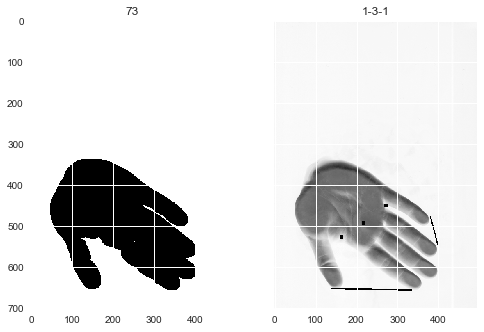

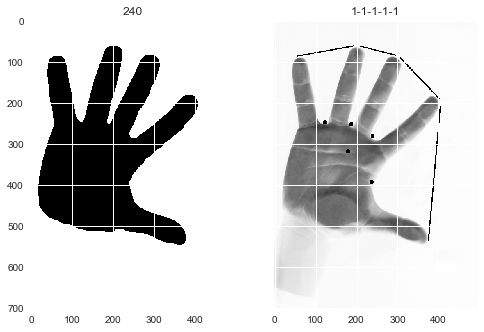

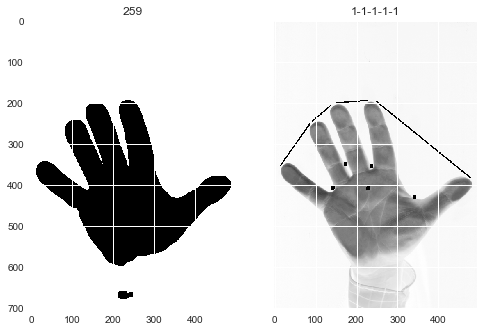

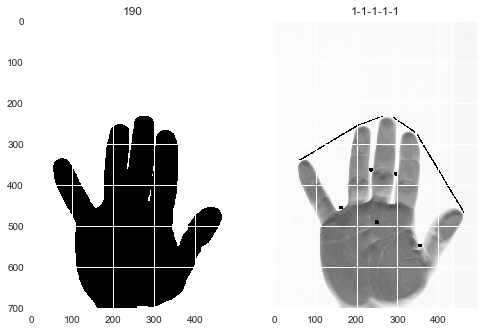

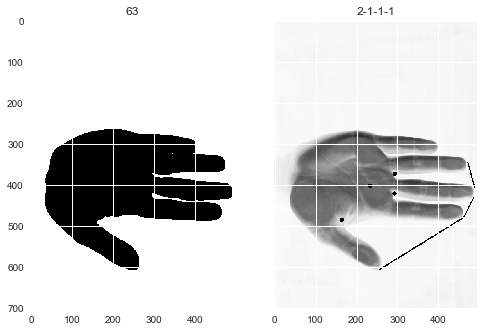

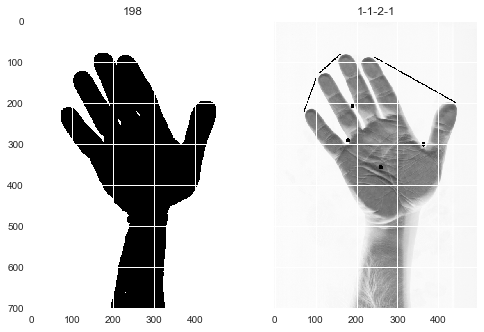

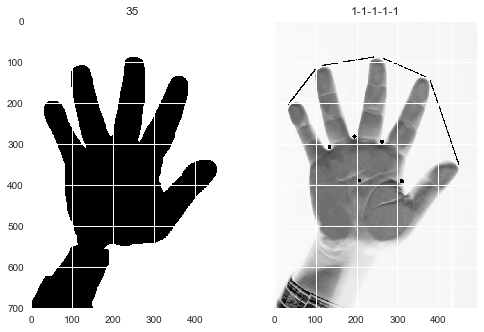

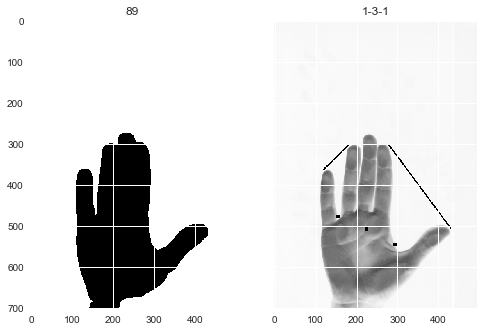

In [187]:
for _ in range(20):
    n = np.random.randint(0, 300)
    img = data[n]
    ret, thresh = cv2.threshold(img,80,255,cv2.THRESH_BINARY)
    median = cv2.medianBlur(thresh, 11)
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(median,kernel,iterations = 2)
    _, contours, hierarchy = cv2.findContours(dilation,2,1)
    cnt_idx = np.argmax([cv2.contourArea(cnt) for cnt in contours])
    cnt = contours[cnt_idx]
    hull = cv2.convexHull(cnt,returnPoints = False)
    defects = cv2.convexityDefects(cnt,hull)
    img2 = img.copy()
    angles = []
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    centroid = tuple([cx, cy])
    ok_defects = sorted(filter(lambda x: x[0][3] > 20000, defects), key=lambda x: np.linalg.norm(cnt[x[0][2]][0] - centroid), reverse=True)
    triangles = []
    for defect in ok_defects:
        s,e,f,d = defect[0]
        start = tuple(cnt[s][0])
        end = tuple(cnt[e][0])
        far = tuple(cnt[f][0])
        #print(d)
        if angle(start, far, end) < 100 and angle(start, far, end) > 10:
            feature = np.round(angle(far, start, end)/angle(far, end, start), 2)
            k = classify(feature)
            if k in triangles:
                if k == 2:
                    k = 1
                elif k == 1:
                    k = 2
                elif k == 4:
                    k = 3
                elif k == 3:
                    k = 4
            if k != 0:
                triangles.append(k)
            cv2.line(img2,start,end,[255,0,0],2)
            cv2.circle(img2,far,5,[255,0,0],-1)
            cv2.circle(img2,centroid, 5,[255,0,0],-1)
        if len(triangles) == 4:
            break
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.set_title(n)
    ax1.imshow(dilation)
    ax2.imshow(img2)
    ax2.set_title("%s"%(to_answer(triangles)))
    

In [32]:
img = data[119].copy()

Text(0.5,1,'[4, 2]')

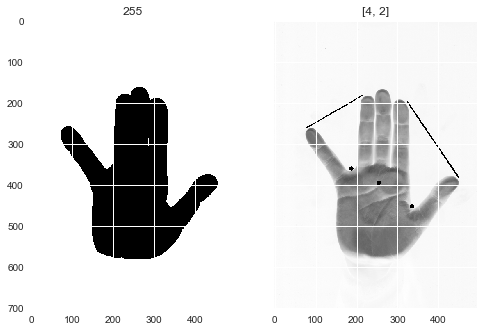

In [184]:
img = data[276]
ret, thresh = cv2.threshold(img,80,255,cv2.THRESH_BINARY)
median = cv2.medianBlur(thresh, 11)
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(median,kernel,iterations = 2)
_, contours, hierarchy = cv2.findContours(dilation,2,1)
cnt_idx = np.argmax([cv2.contourArea(cnt) for cnt in contours])
cnt = contours[cnt_idx]
hull = cv2.convexHull(cnt,returnPoints = False)
defects = cv2.convexityDefects(cnt,hull)
img2 = img.copy()
angles = []
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
centroid = tuple([cx, cy])
ok_defects = sorted(filter(lambda x: x[0][3] > 20000, defects), key=lambda x: np.linalg.norm(cnt[x[0][2]][0] - centroid), reverse=True)
triangles = []
for defect in ok_defects:
    s,e,f,d = defect[0]
    start = tuple(cnt[s][0])
    end = tuple(cnt[e][0])
    far = tuple(cnt[f][0])
    #print(d)
    if angle(start, far, end) < 100:
        feature = np.round(angle(far, start, end)/angle(far, end, start), 2)
        k = classify(feature)
        if k in triangles:
            if k == 2:
                k = 1
            elif k == 1:
                k = 2
            elif k == 4:
                k = 3
            elif k == 3:
                k = 4
        if k != 0:
            triangles.append(k)
        cv2.line(img2,start,end,[255,0,0],2)
        cv2.circle(img2,far,5,[255,0,0],-1)
        cv2.circle(img2,centroid, 5,[255,0,0],-1)
    if len(triangles) == 4:
        break

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title(n)
ax1.imshow(dilation)
ax2.imshow(img2)
ax2.set_title("%s"%(triangles))

In [44]:
len(ok_defects)

2

In [33]:
ret, thresh = cv2.threshold(img,60,255,cv2.THRESH_BINARY)

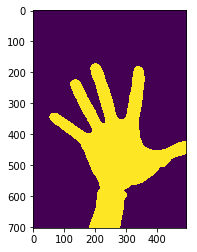

In [34]:
median = cv2.medianBlur(thresh, 9)
imshow(median)

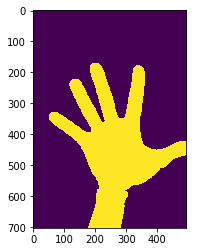

In [35]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(median,kernel,iterations = 1)
imshow(dilation)

In [36]:
_, contours, hierarchy = cv2.findContours(dilation,2,1)

In [37]:
len(contours)

1

In [38]:
cnt = contours[0]

In [131]:
hull = cv2.convexHull(cnt,returnPoints = False)
defects = cv2.convexityDefects(cnt,hull)

In [132]:
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
centroid = tuple([cx, cy])
ok_defects = sorted(filter(lambda x: x[0][3] > 5000, defects), key=lambda x: np.linalg.norm(cnt[x[0][2]][0] - centroid), reverse=True)
len(ok_defects)

5

In [133]:
img = data[34].copy()

for defect in ok_defects:
    s,e,f,d = defect[0]
    start = tuple(cnt[s][0])
    end = tuple(cnt[e][0])
    far = tuple(cnt[f][0])
    if d > 5000 and angle(start, far, end) < 90:
        cv2.line(img,start,end,[255,0,0],2)
        cv2.circle(img,far,5,[255,0,0],-1)

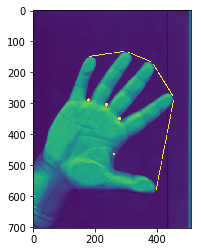

In [134]:
imshow(img)